# Importing the required modules

In [1]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Module for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [4]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

In [5]:
weather = temperature.set_index("date")

# SARIMAX

In [5]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 1), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
     # obtains the forecasts for next five time steps
    def get_forecasts_(self, test_idx):
        return self.trained_model.forecast(steps = 5, exog = self.exogs[test_idx[0]: test_idx[1]])
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])
    
    def plot_predictor_significance(self):
        t = dict()
        for i in self.forecasts:
            _ = self.forecasts[i]["predictor_significance"]
            for j in _:
                if j in t:
                    t[j].append(_[j])
                else:
                    t[j] = [_[j]]

        #print(t)
        df = pd.DataFrame.from_dict(t, orient = "columns")

        # plotting th boxplot
        sns.lineplot(df[["tmin", "tmax", "precip"]], orient = 'x')
        plt.axhline(0.05, ls="--")

        plt.xlabel("ith train-test split")
        plt.ylabel("p-values")
        plt.title(f"p-value of the predictors across different train-test split windows ({self.cluster})")
        plt.show()

In [10]:
m = SARIMAX_model(np.log(electricity), weather, "cluster_1")

In [11]:
m.cross_validate()

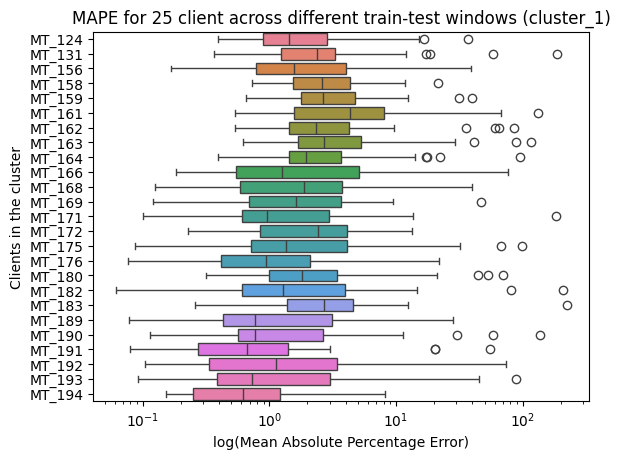

In [8]:
m.mape_boxplot_by_client(25)

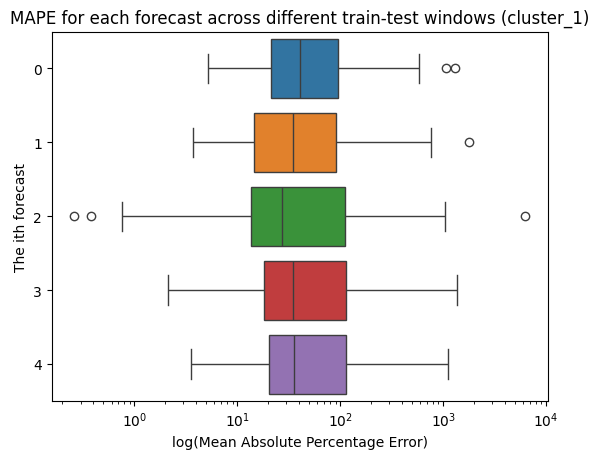

In [12]:
m.mape_boxplot_by_step()

In [13]:
t = dict()
for i in m.forecasts:
    t[i] = m.forecasts[i]["mape_by_forecast"]

df = pd.DataFrame.from_dict(t, orient = "index")
df.describe()

,0,1,2,3,4
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,133.344983,111.699609,232.402865,121.127802,103.815674
std,253.590783,273.998814,911.437078,238.056083,175.654632
min,5.196613,3.725242,0.260515,2.138722,3.573484
25%,21.460238,14.537384,13.648161,18.073903,20.171154
50%,40.864384,34.587986,27.246497,34.987984,35.205652
75%,94.878009,91.982727,111.186550,113.680003,115.141334
max,1306.851096,1767.885215,6254.557889,1353.448886,1109.757343


In [11]:
m = SARIMAX_model(electricity, weather, "cluster_0")

In [12]:
m.cross_validate()

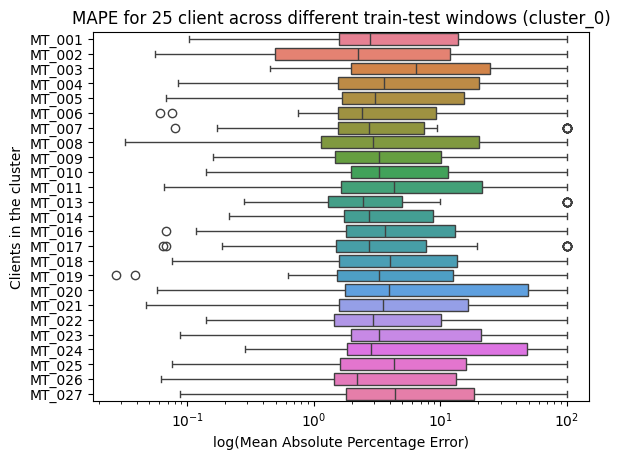

In [13]:
m.mape_boxplot_by_client(25)

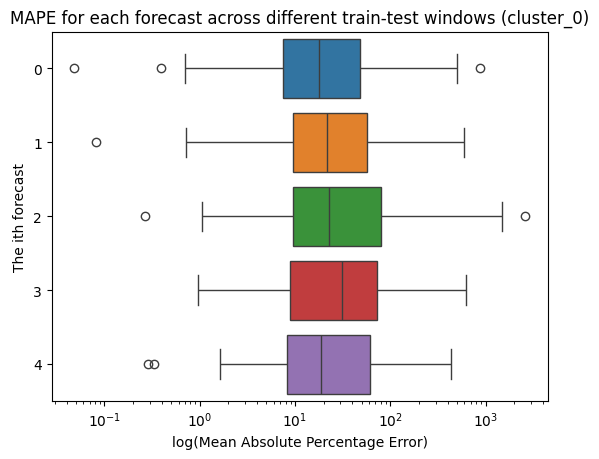

In [14]:
m.mape_boxplot_by_step()

In [15]:
t = dict()
for i in m.forecasts:
    t[i] = m.forecasts[i]["mape_by_forecast"]

df = pd.DataFrame.from_dict(t, orient = "index")
df.describe()

,0,1,2,3,4
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,67.474922,62.985307,180.087515,66.042753,57.692387
std,151.891591,115.336977,481.712736,112.219299,93.908981
min,0.048145,0.081733,0.267557,0.971318,0.285928
25%,7.557843,9.512666,9.610179,8.806592,8.335126
50%,18.148840,21.867385,22.727605,30.884722,18.954658
75%,48.026489,57.691979,79.472136,72.953514,61.679840
max,885.884505,588.148713,2602.775285,624.397825,431.338620


In [19]:
m.trained_model.pvalues

tmin        1.850725e-09
tmax        7.353141e-02
precip      8.645726e-01
ar.L1       1.237780e-01
ma.L1       4.351794e-04
ar.S.L12    2.888590e-09
sigma2      1.632429e-08
dtype: float64

# Facebook Prophet

In [5]:
import prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
class FacebookProphet_model(Model):
    
    def __init__(self, exogs, data, cluster, window_stride=28):
        alldata = data[["date", cluster]].merge(exogs.reset_index())
        alldata = alldata.rename({"date": "ds", cluster:"y"}, axis=1).set_index("ds")
        super().__init__(alldata, "y", window_stride)

    def train_model(self, train, train_idx):
        model = prophet.Prophet()
        for col in self.data.columns:
            if col not in ["ds", "y"]:
                model.add_regressor(col)

        return model.fit(train)
    
    def get_forecasts(self, test, test_idx):

        df = self.trained_model.make_future_dataframe(periods = self.ts_test)

        return self.trained_model.predict(df)["yhat"][test_idx[0]:test_idx[0] + self.ts_test]
        

In [7]:
electricity_ = electricity.reset_index()
electricity_["date"] = pd.to_datetime(electricity_["date"])
m = FacebookProphet_model(weather, electricity_, "cluster_0")

In [8]:
m.cross_validate()

KeyError: "None of [Index([('y',)], dtype='object')] are in the [columns]"

In [90]:
df = electricity[["cluster_1"]].reset_index()
df["date"] = pd.to_datetime(df["date"])
df = df.merge(weather.reset_index())

In [91]:
df

,date,cluster_1,tmin,tmax,precip
0,2011-01-01,6.810210e+06,12.5,17.6,0.6
1,2011-01-02,1.107161e+07,10.0,17.2,0.4
2,2011-01-03,1.118024e+07,9.7,12.0,0.0
3,2011-01-04,1.139913e+07,9.6,13.1,0.0
4,2011-01-05,1.145297e+07,11.5,15.5,3.6
...,...,...,...,...,...
1456,2014-12-27,9.185029e+06,9.4,15.1,0.0
1457,2014-12-28,8.974190e+06,10.8,14.1,0.0
1458,2014-12-29,9.055549e+06,7.0,16.2,0.0
1459,2014-12-30,9.170889e+06,4.0,11.4,0.0


In [92]:
df = df.rename({"date": "ds", "cluster_1":"y"}, axis=1)

In [93]:
df

,ds,y,tmin,tmax,precip
0,2011-01-01,6.810210e+06,12.5,17.6,0.6
1,2011-01-02,1.107161e+07,10.0,17.2,0.4
2,2011-01-03,1.118024e+07,9.7,12.0,0.0
3,2011-01-04,1.139913e+07,9.6,13.1,0.0
4,2011-01-05,1.145297e+07,11.5,15.5,3.6
...,...,...,...,...,...
1456,2014-12-27,9.185029e+06,9.4,15.1,0.0
1457,2014-12-28,8.974190e+06,10.8,14.1,0.0
1458,2014-12-29,9.055549e+06,7.0,16.2,0.0
1459,2014-12-30,9.170889e+06,4.0,11.4,0.0


In [94]:
p = prophet.Prophet()
p = p.fit(df[0:200][["ds", "y"]])
x = p.make_future_dataframe(periods=5)
o = p.predict(x)["yhat"][200:]
mean_absolute_percentage_error(df["y"][200:205], o)*100

00:02:47 - cmdstanpy - INFO - Chain [1] start processing


00:02:47 - cmdstanpy - INFO - Chain [1] done processing


1.5183494715686618

In [98]:
p.predict(x)["yhat"]

0      9.562201e+06
1      9.846119e+06
2      9.827929e+06
3      9.661150e+06
4      9.998648e+06
           ...     
200    1.215597e+07
201    1.175685e+07
202    1.185713e+07
203    1.155882e+07
204    1.171878e+07
Name: yhat, Length: 205, dtype: float64

In [96]:
p = prophet.Prophet()
for col in weather.columns:
    p.add_regressor(col)
p = p.fit(df[365:565])
x = p.make_future_dataframe(periods=5).merge(df).drop(["y"], axis = 1)
o = p.predict(x)["yhat"][565:]
mean_absolute_percentage_error(df["y"][565:570], o)*100

00:03:37 - cmdstanpy - INFO - Chain [1] start processing
00:03:37 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Found input variables with inconsistent numbers of samples: [5, 0]

In [44]:
p.predict(p.make_future_dataframe(periods=730))["yhat"]

0       4.599886e+04
1       1.597333e+05
2       4.461768e+04
3       4.534651e+04
4       4.499772e+04
            ...     
1091    1.453943e+06
1092    1.457210e+06
1093    1.572404e+06
1094    1.458748e+06
1095    1.460936e+06
Name: yhat, Length: 1096, dtype: float64